# Assignment 2
The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [1]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2020-12-17 01:04:22--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.172.112, 2600:141b:f000:9b4::e59, 2600:141b:f000:9b3::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.200.172.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M   230MB/s    in 0.2s    

2020-12-17 01:04:23 (230 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



In [2]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

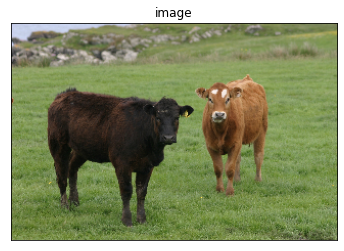

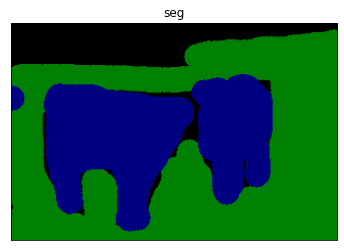

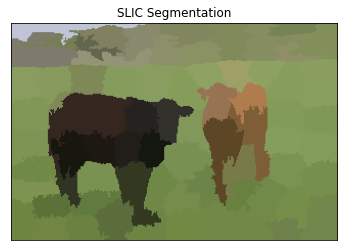

In [3]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [4]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [5]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




In [6]:
from IPython.display import Image
Image(filename='data_preprocessing.png') 

FileNotFoundError: ignored

In [7]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.
from google.colab.patches import cv2_imshow
from skimage import io
from tqdm import tqdm
import csv

if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

if not os.path.exists(os.path.join(msrc_directory, "images")):
    os.makedirs(os.path.join(msrc_directory, "images"))

if not os.path.exists(os.path.join(msrc_directory, "gt_segmasks")):
    os.makedirs(os.path.join(msrc_directory, "gt_segmasks"))

if not os.path.exists(os.path.join(msrc_directory, "images_train")):
    os.makedirs(os.path.join(msrc_directory, "images_train"))

if not os.path.exists(os.path.join(msrc_directory, "images_val")):
    os.makedirs(os.path.join(msrc_directory, "images_val"))

write_train = open(msrc_directory + '/train.txt', 'w+')
write_val = open(msrc_directory + '/val.txt', 'w+')

img_dir_train = msrc_directory + "/images_train"
img_dir_val = msrc_directory + "/images_val"

image_stack = np.zeros((224, 224, 3))

def dilate(x_coords, y_coords, image):
  height, width, _ = image.shape
  coordinates = [max(0, min(x_coords)-3), 
                 max(0, min(y_coords)-3), 
                 min(width, max(x_coords)+3), 
                 min(height, max(y_coords)+3)]
  #print('coordinates', coordinates)
  patch = image[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]
  dilated_patch = cv2.resize(patch, (224, 224), interpolation = cv2.INTER_AREA)
  return dilated_patch, coordinates

def getPatchLabel(image: float, coordinates) -> int:
  patch_seg = image[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]
  num = 0
  classes = np.unique(patch_seg)
  for label in classes:
    labels = len(np.where(patch_seg == label)[0])
    if labels > num:
        num = labels
        label_final = label
  return int(label_final)

def imageSegLabels(img_seg_labels):
  image_seg_labels = np.zeros((image_seg.shape[0], 
                               image_seg.shape[1]))
  for i in range(image_seg.shape[0]):
      for j in range(image_seg.shape[1]):
#             print(tuple(seg_image[i][j][::-1]), tuple(seg_image[i][j]))
          try:
              image_seg_labels[i][j] = rgb_2_label[tuple(image_seg[i][j][::-1])]
          except:
              image_seg_labels[i][j] = -1
  
  return image_seg_labels

for filename in os.listdir(msrc_directory):
    # Your code 
    try:
      msrc_path = msrc_directory + '/' + filename
      msrc_path_seg = msrc_directory + '/' + filename[:-4] + '_GT.bmp'
      if (not msrc_path.endswith('GT.bmp')):
        image = io.imread(msrc_path)
        image_seg =  io.imread(msrc_path_seg)
        img_seg_labels = imageSegLabels(image_seg)
        # Splitting the data in 80:20
        rand = np.random.uniform()
        if rand < 0.80:
            mode = 'train'
            img_dir = img_dir_train
            write_file = write_train
            normed_image = image/255
            normed_image = cv2.resize(normed_image, 
                                      (224, 224), 
                                      interpolation = cv2.INTER_AREA)
            image_stack = np.vstack((image_stack, normed_image))
        else:
            mode = 'val'
            img_dir = img_dir_val
            write_file = write_val
        # Applying SLIC on the RGB images
        segments = slic(image, n_segments=100, compactness=10) 
        # Number of classes of the superpixel segments
        classes = np.unique(segments)
        #print('msrc_path', msrc_path)
        #print('classes', segments)
        #plot_image(image, 'image')
        #superpixel_plot(image,segments, title = "SLIC Segmentation")
        # (Segment patch, id label) saved as CSV file
        csv_path = img_dir + '/' + filename + '.csv'
        csv_path_combined = img_dir + '/' + mode + '_dataset.csv'
        #print('csv_path', csv_path)
        #print('csv_path_combined', csv_path_combined)
        
        with open(csv_path_combined, mode='a') as combined_data:
          with open(csv_path, mode='a') as superpixel_csv:
            csv_writer = csv.DictWriter(superpixel_csv, 
                                        fieldnames=['patch_path', 
                                                    'coordinates',
                                                    'label'])
            csv_writer_comb = csv.DictWriter(combined_data, 
                                             fieldnames=['patch_path', 
                                                         'coordinates',
                                                         'label'])
            # Get indices of the superpixel segment map
            for idx, class_id in enumerate(tqdm(classes)):
              indices = np.where(segments == class_id)
              y_coords = indices[0]
              x_coords = indices[1]
              
              # Get the dilated rectangle
              dilated_patch, coordinates = dilate(x_coords, y_coords, image)
              #cv2_imshow(dilated_patch)
              #Get the patch label
              patch_label = getPatchLabel(img_seg_labels, coordinates)
              #print('patch_label', patch_label)
              # Save dilated patch as numpy 
              filename = filename.replace('.bmp', '')
              np_path = img_dir + '/' + filename + '_' + str(idx) + '.npy'
              #print('np_path:', np_path)
              np.save(np_path, dilated_patch)
              # Write npy filenames in train or val txt
              write_file.write(np_path + '\n')
              csv_writer.writerow({'patch_path': np_path, 
                                   'coordinates': coordinates,
                                   'label': patch_label})
              csv_writer_comb.writerow({'patch_path': np_path, 
                                        'coordinates': coordinates,
                                        'label': patch_label})
    except:
      print('Corrupt file:', filename)
write_file.close()

100%|██████████| 72/72 [00:00<00:00, 837.44it/s]


Corrupt file: images_train


100%|██████████| 67/67 [00:00<00:00, 776.71it/s]


Corrupt file: images


100%|██████████| 66/66 [00:00<00:00, 768.49it/s]


Corrupt file: MSR Cambridge EULA for Digital Images_download.rtf


100%|██████████| 58/58 [00:00<00:00, 687.51it/s]


Corrupt file: images_val


100%|██████████| 65/65 [00:00<00:00, 771.27it/s]


Corrupt file: train.txt


100%|██████████| 69/69 [00:00<00:00, 711.83it/s]


Corrupt file: val.txt


100%|██████████| 76/76 [00:00<00:00, 807.46it/s]


Corrupt file: ClickMe.html


100%|██████████| 34/34 [00:00<00:00, 556.92it/s]


Corrupt file: gt_segmasks


100%|██████████| 73/73 [00:00<00:00, 818.51it/s]


Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [8]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self, root_dir, csv_file, transform=False):
        # Your code 
        self.root_dir = root_dir
        self.csv_path = self.root_dir + '/' + csv_file
        self.msrc_data = pd.read_csv(self.csv_path)
        self.transform = transform
            
    def __len__(self):
        # Your code 
        return len(self.msrc_data)
    
    def __getitem__(self, index):
        # Your code 
        if torch.is_tensor(index):
            index = index.tolist()

        np_path = self.msrc_data.iloc[index, 0]
        #print('label: ', self.msrc_data.iloc[index, 2])
        label = self.msrc_data.iloc[index, 2] + 1 # Might need to remove 1 here
        
        image = np.load(np_path)
        image = Image.fromarray(np.uint8(image))
        sample = {}
        if self.transform:
            sample['superpixel_img'] = self.transform(image)
            sample['superpixel_label'] = torch.tensor(label)

        return sample


## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [9]:
# Model definition
# class SegmentationNN(nn.Module):
#     def __init__(self, pretrained_model):
#         # Your code 
#         self.model = pretrained_model
#         self.fcl = nn.Sequential(
#             nn.Linear(1280 , 512),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.2),
#             nn.Linear(512 , 256),
#             nn.Linear(256 , 24)
#         ) 
#         self.features = nn.Sequential(*list(self.model.children())[:-1])
        
#     def forward(self):
#         # Your code 
#         pass


## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [10]:
# Optimizer 
class Solver(object):
    def __init__(self, model, lr = 0.0001):
        # Your code 
        self.lr = lr
        self.model = model
        self.optimizer = torch.optim.SGD(self.model.parameters(), 
                                         lr=self.lr, 
                                         weight_decay=0.0002, 
                                         momentum=0.9)
        self.lr_schedule = [5, 10, 15]
        self.loss = torch.nn.CrossEntropyLoss()
    
    def decay_lr(self, epoch):
        if epoch in self.lr_schedule:
            for param_group in self.optimizer.param_groups:
                self.lr *= 0.1

    def train(self, dataloader):
        # Your code 
        self.model.train()
        device = 'cuda'
        correct = 0
        total = 0
        loss_train = 0

        for batch_id, sample in enumerate(dataloader):
            #print('batch_id:', batch_id)
            input = sample['superpixel_img'].to(device)
            target = sample['superpixel_label'].to(device)
            self.optimizer.zero_grad()
            outputs = self.model(input)
            #print('output shape:', outputs.shape)
            #print('target shape:', target.shape)
            loss = self.loss(outputs, target)
            loss.backward()
            self.optimizer.step()       
            _, prediction = outputs.max(1)
            total += target.size(0)
            correct += prediction.eq(target).sum().item()
            loss_train += loss.item()
        
        accuracy = 100.0*(correct/total)
        loss_train = loss_train / (1 + batch_id)
        
        return loss_train, accuracy

    def test(self, dataloader):
        self.model.eval()
        device = 'cuda'
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_id, sample in enumerate(dataloader):
                #print('batch_id', batch_id)
                input = sample['superpixel_img'].to(device)
                target = sample['superpixel_label'].to(device)
                test_output = self.model(input)
                _, prediction = test_output.max(1)
                correct += prediction.eq(target).sum().item()
                total += target.size(0)
        
        accuracy = 100.0*(correct/ total)

        return accuracy

## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

In [13]:
# load the data
# Transforms
transform_list_train = [transforms.RandomCrop(224, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor()]

transform_train = transforms.Compose(transform_list_train)

transform_list_val = [transforms.ToTensor()]

transform_val = transforms.Compose(transform_list_val)

dataset_train = SegmentationData(root_dir='./MSRC_ObjCategImageDatabase_v1/images_train',
                                 csv_file='train_dataset.csv', 
                                 transform = transform_train)

dataset_val = SegmentationData(root_dir='./MSRC_ObjCategImageDatabase_v1/images_val',
                               csv_file='val_dataset.csv', 
                               transform = transform_val)

# data loader
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=4)

dataloader_val = torch.utils.data.DataLoader(dataset_val,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=4)
# model
device = 'cuda'
model = models.vgg19(pretrained=True)
#print('Model: ', model)
model.classifier[6] = nn.Linear(4096, 24)
#print('Modified model: ', model)
model = model.to(device)

# train the model
solver = Solver(model)
for epoch in tqdm(range(0, 20)):
    print('epoch: ', epoch)
    solver.decay_lr(epoch)
    loss, accuracy = solver.train(dataloader=dataloader_train)
    print('Train Loss:', loss)
    print('Train Accuracy:', accuracy)
    
    if epoch % 5 == 0:
        accuracy = solver.test(dataloader=dataloader_val)
        print('Test Accuracy: ', accuracy)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:  0
Train Loss: 0.5373484741363254
Train Accuracy: 80.9277921212626


  5%|▌         | 1/20 [06:58<2:12:22, 418.02s/it]

Test Accuracy:  88.24786324786325
epoch:  1


 10%|█         | 2/20 [13:32<2:03:19, 411.10s/it]

Train Loss: 0.33111968998451174
Train Accuracy: 87.83209794286665
epoch:  2


 15%|█▌        | 3/20 [20:08<1:55:08, 406.36s/it]

Train Loss: 0.26048303750696666
Train Accuracy: 90.5138669109686
epoch:  3


 20%|██        | 4/20 [26:43<1:47:27, 402.95s/it]

Train Loss: 0.21781204536167156
Train Accuracy: 92.12959107187474
epoch:  4


 25%|██▌       | 5/20 [33:18<1:40:10, 400.70s/it]

Train Loss: 0.18803395494635805
Train Accuracy: 93.09569417839595
epoch:  5
Train Loss: 0.16174611591387963
Train Accuracy: 94.22836678604148


 30%|███       | 6/20 [40:21<1:35:01, 407.26s/it]

Test Accuracy:  91.27492877492878
epoch:  6


 35%|███▌      | 7/20 [46:57<1:27:29, 403.80s/it]

Train Loss: 0.14598242704147374
Train Accuracy: 94.66144748896477
epoch:  7


 40%|████      | 8/20 [53:32<1:20:17, 401.42s/it]

Train Loss: 0.12740725432561034
Train Accuracy: 95.11951361705671
epoch:  8


 45%|████▌     | 9/20 [1:00:08<1:13:16, 399.73s/it]

Train Loss: 0.10939139462871214
Train Accuracy: 95.96068959773464
epoch:  9


 50%|█████     | 10/20 [1:06:44<1:06:24, 398.46s/it]

Train Loss: 0.09645211516699861
Train Accuracy: 96.35212792537686
epoch:  10
Train Loss: 0.08686285871348183
Train Accuracy: 96.97676355459316


 55%|█████▌    | 11/20 [1:13:46<1:00:51, 405.74s/it]

Test Accuracy:  89.67236467236467
epoch:  11


 60%|██████    | 12/20 [1:20:22<53:41, 402.64s/it]  

Train Loss: 0.07908985598990631
Train Accuracy: 97.11834763054885
epoch:  12


 65%|██████▌   | 13/20 [1:26:57<46:43, 400.49s/it]

Train Loss: 0.0683913830141246
Train Accuracy: 97.58474223369701
epoch:  13


 70%|███████   | 14/20 [1:33:32<39:53, 398.90s/it]

Train Loss: 0.0662271690102005
Train Accuracy: 97.66802698425919
epoch:  14


 75%|███████▌  | 15/20 [1:40:08<33:09, 397.85s/it]

Train Loss: 0.0607753594869229
Train Accuracy: 97.967852086283
epoch:  15
Train Loss: 0.05234022758581895
Train Accuracy: 98.07612226201383


 80%|████████  | 16/20 [1:47:11<27:01, 405.32s/it]

Test Accuracy:  90.17094017094017
epoch:  16


 85%|████████▌ | 17/20 [1:53:46<20:07, 402.34s/it]

Train Loss: 0.045530534219699874
Train Accuracy: 98.40926126426251
epoch:  17


 90%|█████████ | 18/20 [2:00:21<13:20, 400.23s/it]

Train Loss: 0.04482360980220207
Train Accuracy: 98.46756058965603
epoch:  18


 95%|█████████▌| 19/20 [2:06:56<06:38, 398.70s/it]

Train Loss: 0.03615079319018003
Train Accuracy: 98.83401349212959
epoch:  19


100%|██████████| 20/20 [2:13:32<00:00, 400.61s/it]

Train Loss: 0.040484620479233624
Train Accuracy: 98.79237111684851


## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

In [ ]:
#TODO




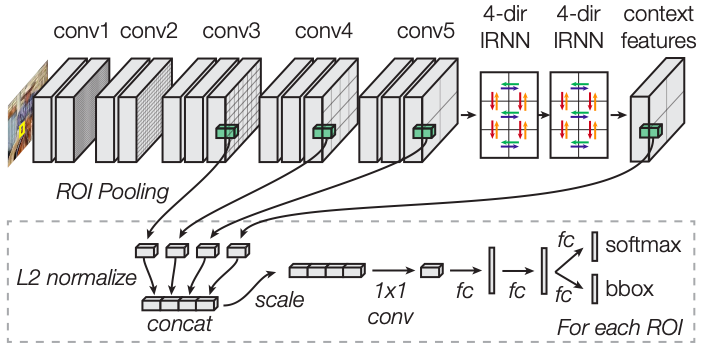

In [ ]:
from IPython.display import Image
Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [ ]:
#TODO




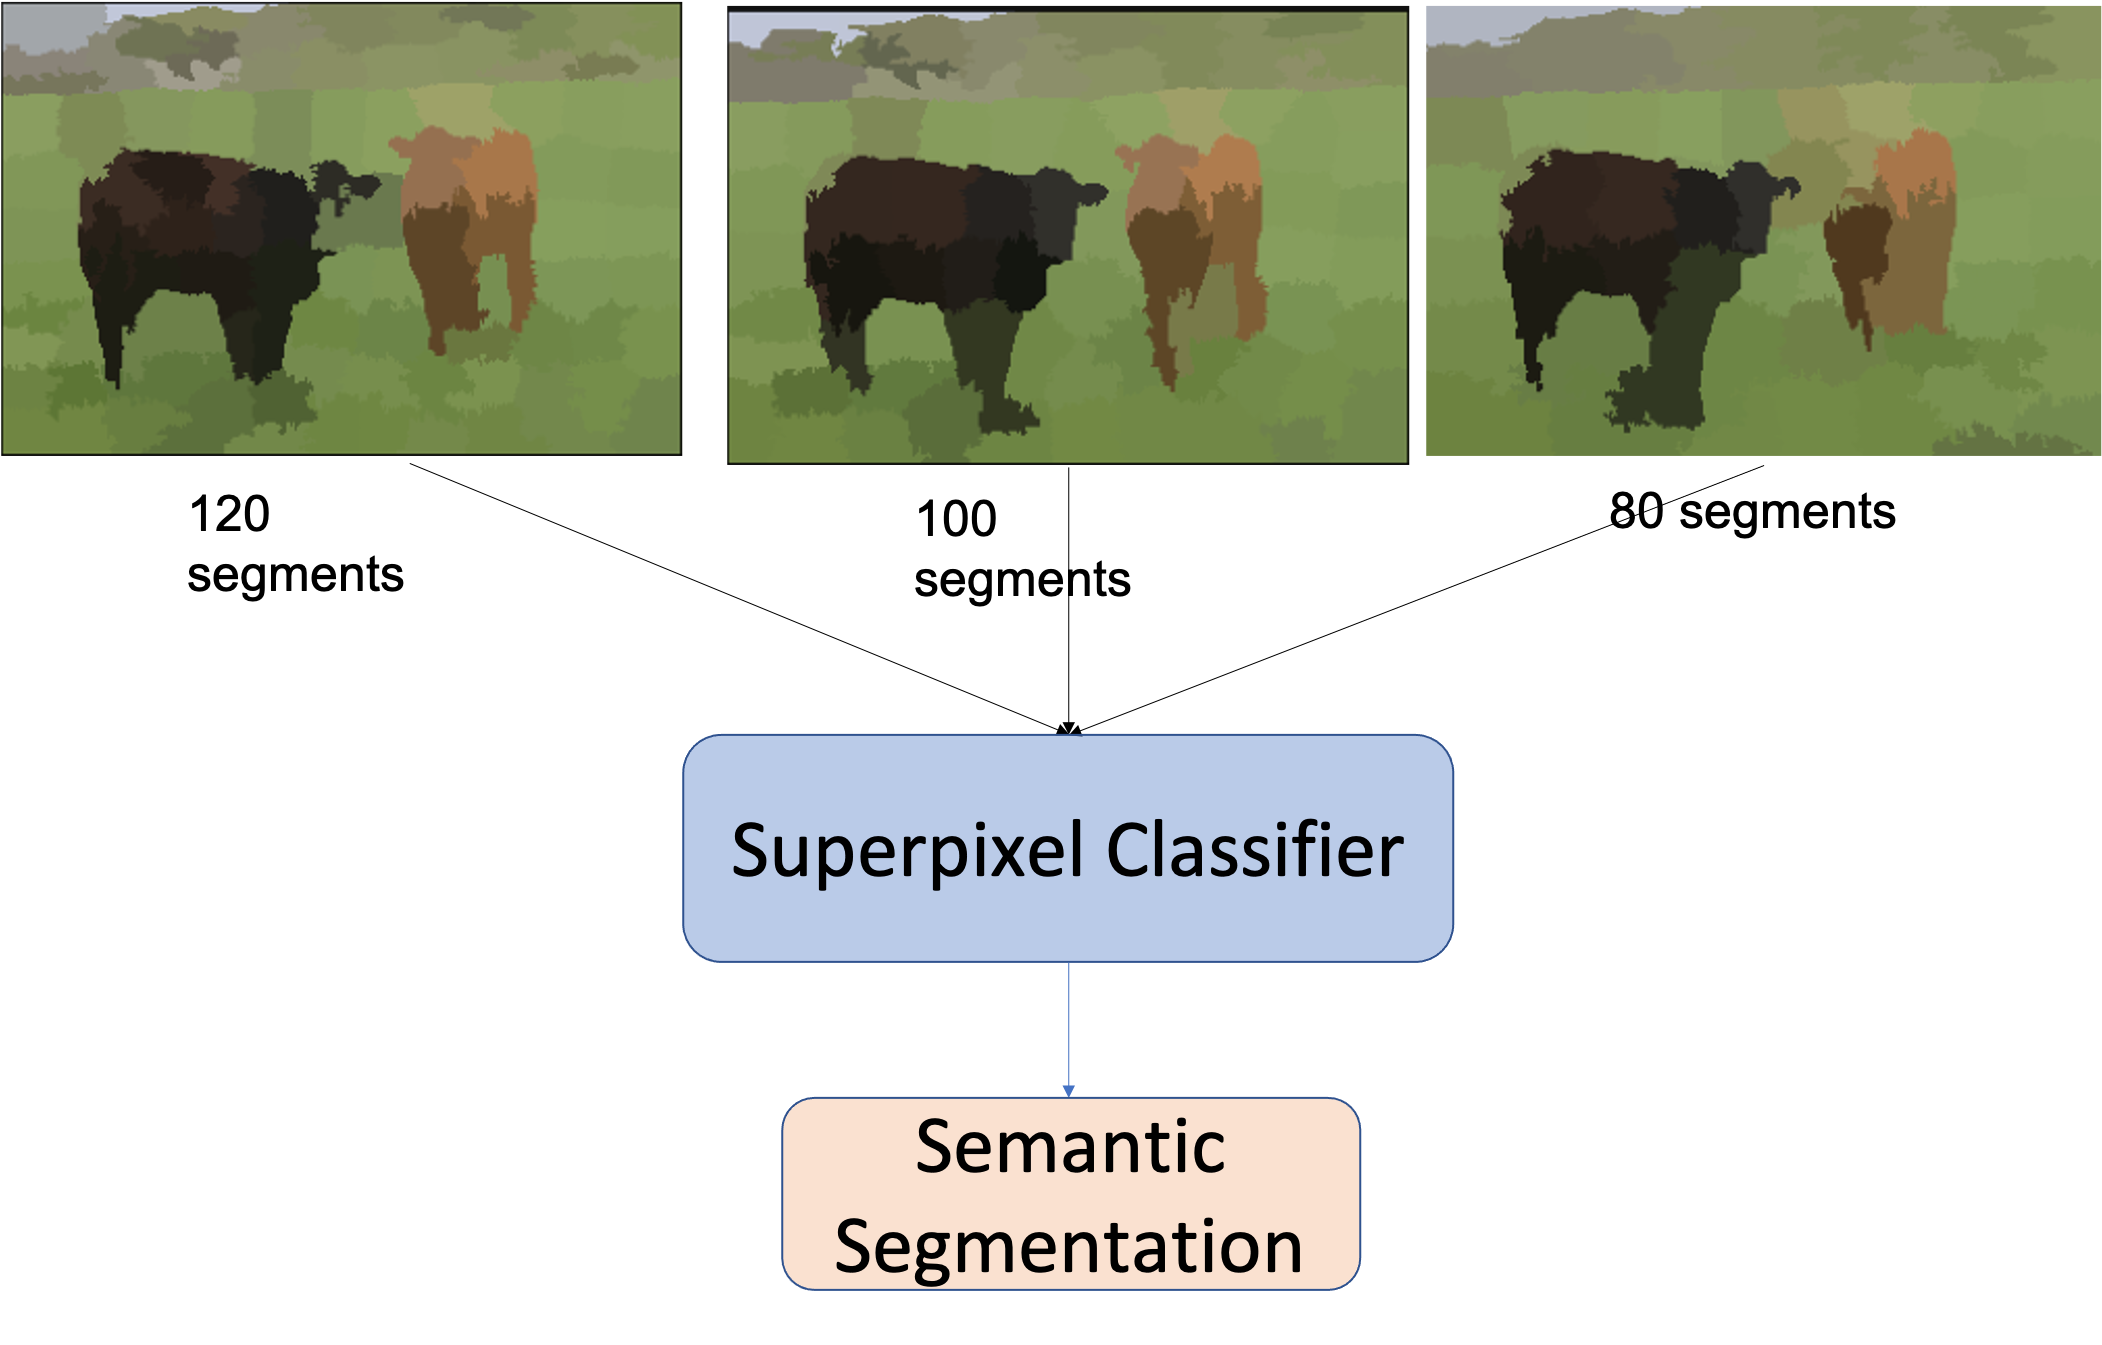

In [ ]:
from IPython.display import Image
Image(filename='/Multi-resolution.png') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features